# Low-rank nonnegative tensor approximation via alternating projections and sketching

In [1]:
##
%reload_ext autoreload
%autoreload 2
##
import sys
sys.path.append('./src')

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from time import time

from truncatedSvd import TruncatedSvd
from experiment import Experiment

In [2]:
%%bash
lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   39 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          4
On-line CPU(s) list:             0-3
Vendor ID:                       GenuineIntel
Model name:                      Intel(R) Core(TM) i3-8130U CPU @ 2.20GHz
CPU family:                      6
Model:                           142
Thread(s) per core:              2
Core(s) per socket:              2
Socket(s):                       1
Stepping:                        10
BogoMIPS:                        4416.00
Flags:                           fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology cpuid pni pclmulqdq vmx ssse3 fma cx16 pcid sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single 

## 1. Multidimensional Gaussian mixture

In [3]:
t0 = time()

N = 128
N1 = N
N2 = N
N3 = N
A = np.zeros([N1, N2,N3])
cov_mat = np.random.uniform(0, 1, [3,3])
cov_mat = cov_mat @ cov_mat.T
cov_mat = cov_mat / np.linalg.norm(cov_mat)
cov_mat2 = np.random.uniform(0, 1, [3,3])
cov_mat2 = cov_mat2 @ cov_mat2.T
cov_mat2 = cov_mat2 / np.linalg.norm(cov_mat2)

cov_mat3 = np.random.uniform(0, 1, [3,3])
cov_mat3 = cov_mat3 @ cov_mat3.T
cov_mat3 = cov_mat3 / np.linalg.norm(cov_mat3)

h = 4. / N
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            point = np.array([i*h, j*h, k*h])
            A[i,j,k] = np.exp(-point @ cov_mat  @ point) +\
                       np.exp(-point @ cov_mat2 @ point) +\
                       np.exp(-point @ cov_mat3 @ point)
            
print('%d s.' % (time() - t0))

100 s.


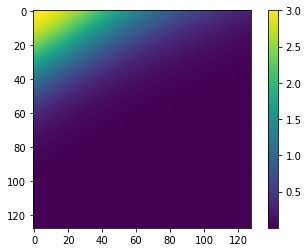

In [4]:
plt.imshow(A[:, :, 0])
_ = plt.colorbar()

In [249]:
nsthosvdTruncatedSvdList = []
nsthosvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=1,  k=15))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=0,  k=16))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=10, l=25))
# nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=6,  l=11))

nttsvdTruncatedSvdList = []
nttsvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=1, k=14))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT',   p=0, k=14))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=7, l=29))
# nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=6, l=10))

nlrtTruncatedSvdList = []
nlrtTruncatedSvdList.append(TruncatedSvd('SVDr'))


tuckerRank = (5, 5, 5)
ttRank = (5, 5)
itersNum = 100

ex = Experiment(tensor=A,
                tuckerRank=tuckerRank,
                ttRank=ttRank,
                nsthosvdTruncatedSvdList=nsthosvdTruncatedSvdList,
                nttsvdTruncatedSvdList=nttsvdTruncatedSvdList,
                nlrtTruncatedSvdList=nlrtTruncatedSvdList)

In [179]:
ex.runInitialSvd()

TTSVD
-------------------------------------------
time (s.)                    |      0.33635
negative elements (fro)      |     0.001032
negative elements (che)      |     0.000009
negative elements (%)        |   6.09874725
relative error (fro)         | 0.0000572640
relative error (che)         | 0.0002051583
r2_score                     | 0.9999999965
compression                  |       468.11
-------------------------------------------
STHOSVD
-------------------------------------------
time (s.)                    |      0.31274
negative elements (fro)      |     0.003240
negative elements (che)      |     0.000033
negative elements (%)        |   7.03477859
relative error (fro)         | 0.0001242895
relative error (che)         | 0.0005666560
r2_score                     | 0.9999999833
compression                  |      1025.50
-------------------------------------------


In [58]:
ex.time(itersNum, nttsvd=True, nsthosvd=False, nlrt=False)

NTTSVD
------------------------------------
SVD$_r$                 |  45.93 s.
HMT(1,14), Rad          |  11.42 s.
HMT(0,14), Rad          |   8.09 s.
Tropp(7,29), Rad        |   6.36 s.
------------------------------------


In [59]:
ex.time(itersNum, nttsvd=False, nsthosvd=True, nlrt=False)

NSTHOSVD
------------------------------------
SVD$_r$                 |  45.62 s.
HMT(1,15), Rad          |  12.18 s.
HMT(0,16), Rad          |   8.53 s.
Tropp(10,25), Rad       |   7.54 s.
------------------------------------


In [181]:
ex.time(itersNum, nttsvd=False, nsthosvd=False, nlrt=True)

NLRT
------------------------------------
SVD$_r$                 | 113.34 s.
------------------------------------


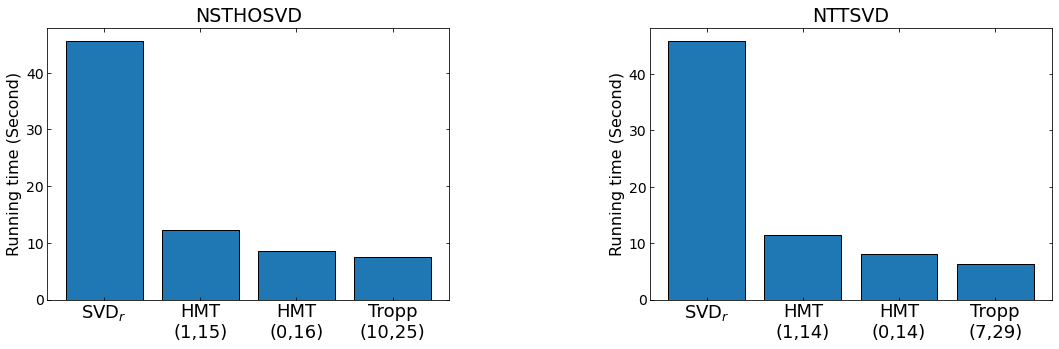

In [60]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=19,
                          ylabelsize=16,
                          xticksize=18,
                          yticksize=14,
                          wspace=0.5,
                          paramsNewLine=True)

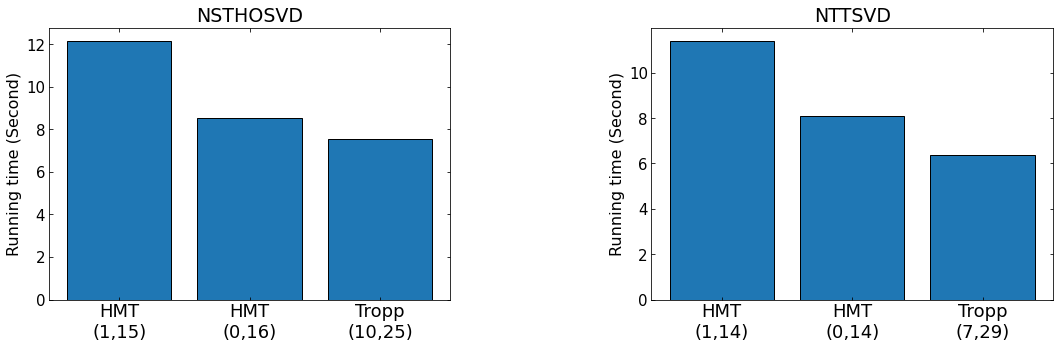

In [61]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=19,
                          ylabelsize=16,
                          xticksize=18,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True,
                          exclude=[0])

In [182]:
ex.run(itersNum)

NTTSVD
------------------------------------
SVD$_r$                  |  39.61 s.
HMT(1,14), Rad           |   7.76 s.
HMT(0,14), Rad           |   7.04 s.
Tropp(7,29), Rad         |   6.79 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  |  40.43 s.
HMT(1,15), Rad           |   8.95 s.
HMT(0,16), Rad           |   7.48 s.
Tropp(10,25), Rad        |   7.33 s.
------------------------------------
NLRT
------------------------------------
SVD$_r$                  | 164.36 s.
------------------------------------


In [250]:
ex.run(itersNum, nttsvd=False, nsthosvd=False, nlrt=True) #

NLRT
------------------------------------
SVD$_r$                  | 164.47 s.
------------------------------------


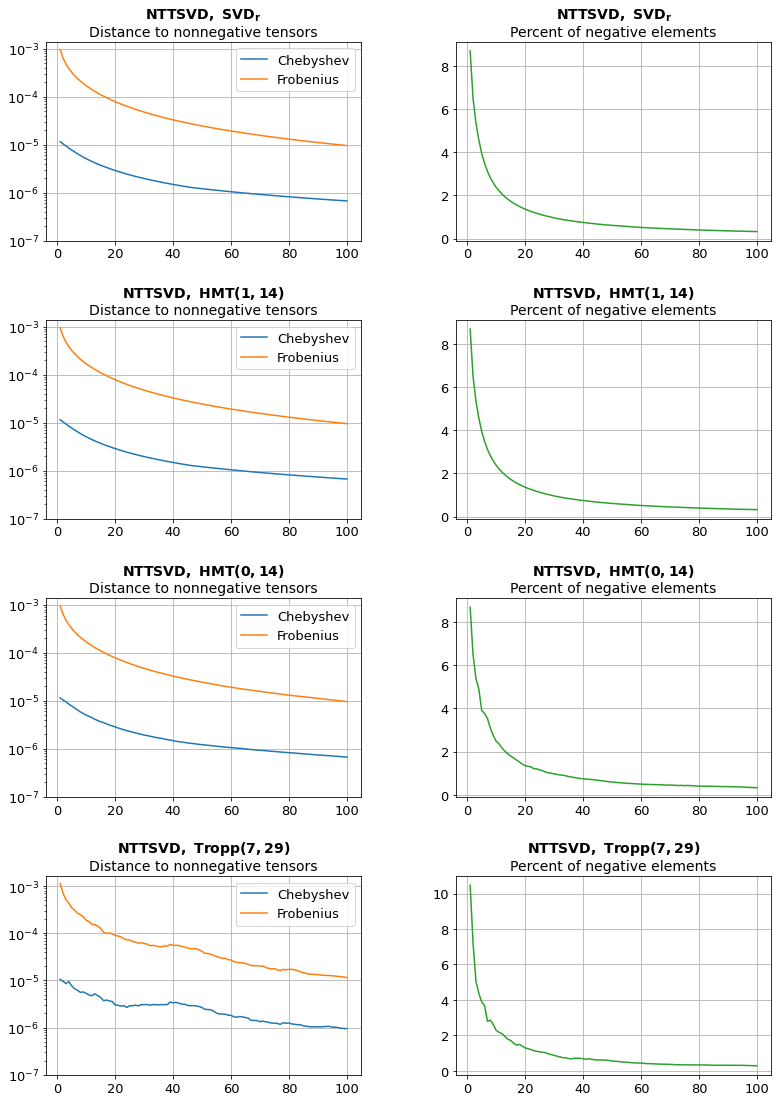

In [52]:
fig, ax = ex.plotConvergence2(nsthosvd=False,
                              figsize=(13, 19),
                              yticks=[10**(-x) for x in range(3, 8)],
                              hspace=0.4, wspace=0.3,
                              titlesize=14,
                              ticksize=13,
                              legendsize=13,
                              legendloc='upper right')

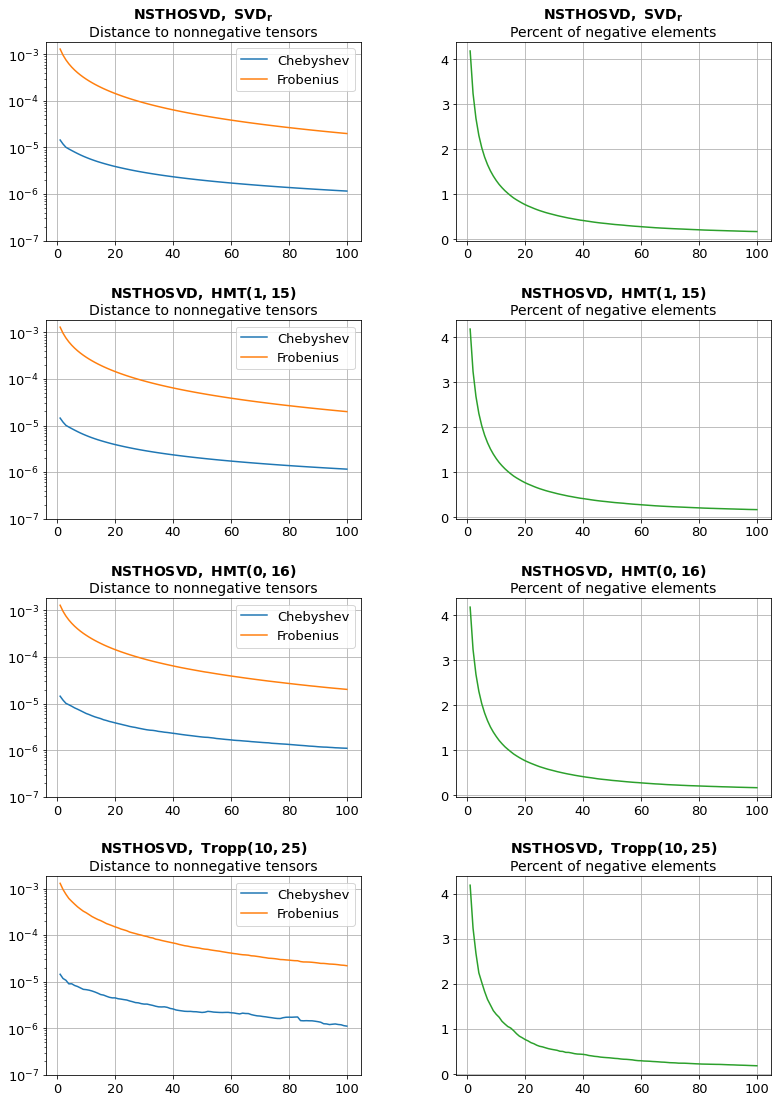

In [53]:
fig, ax = ex.plotConvergence2(nttsvd=False,
                              figsize=(13, 19),
                              yticks=[10**(-x) for x in range(3, 8)],
                              hspace=0.4, wspace=0.3,
                              titlesize=14,
                              ticksize=13,
                              legendsize=13,
                              legendloc='upper right')

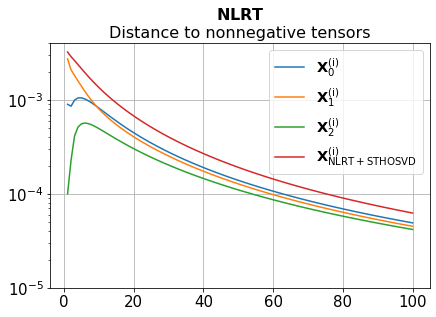

In [265]:
fig, ax = ex.plotConvergence(nttsvd=False,
                       nsthosvd=False,
                       nlrt=True,
                       figsize=(6.8, 4.5),
                       titlesize=16,
                       ticksize=15,
                       legendsize=14.5,
                       yticks=[10**(-x) for x in range(3, 6)])

In [183]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) | r2_score |
-------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000057600115839565 | 0.000205374426448450 | 1.000000 |
| HMT(1,14), Rad           | 0.000057600115839617 | 0.000205374425812810 | 1.000000 |
| HMT(0,14), Rad           | 0.000057603141669597 | 0.000205444398780378 | 1.000000 |
| Tropp(7,29), Rad         | 0.000058476986584210 | 0.000249658938433169 | 1.000000 |
-------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) | r2_score |
-------------------------------------------------------------------------------------
| SVD$_r$                  | 0.000125954224068775 | 0.000569477996757328 | 1.000000 |
| HMT(1,15), Rad           | 0.000125954224068875 | 0.000569477996406942 | 1.000000 |
| HMT(0,16), Rad           | 0.000125958415053386 | 0.

In [184]:
ex.printNegativePart()

| NTTSVD                   | negative elements (%) |
----------------------------------------------------
| SVD$_r$                  |             0.2448559 |
| HMT(1,14)                |             0.2448559 |
| HMT(0,14)                |             0.2440453 |
| Tropp(7,29)              |             0.2487183 |
| NSTHOSVD                 | negative elements (%) |
----------------------------------------------------
| SVD$_r$                  |             0.2318859 |
| HMT(1,15)                |             0.2318859 |
| HMT(0,16)                |             0.2310753 |
| Tropp(10,25)             |             0.2630234 |

----------------------------------------------------------------
| NLRT                     | negative elements (%) |       X_i |
----------------------------------------------------------------
| SVD$_r$                  |             0.3668308 |       X_0 |
|                          |             0.3382206 |       X_1 |
|                          |          

# 2. Function Based Tensors

## 2.1 Hilbert Tensor

An Nth order Hilbert tensor is defined as follows
$$A(i_1, \dots, i_N) = \frac{1}{i_1 + \dots + i_N - N + 1}$$

In [288]:
shape = [128, 128, 128]

a = np.empty(shape=shape)

m, n, l = a.shape
for i in range(m):
    for j in range(n):
        for k in range(l):
            a[i, j, k] = 1 / ((i+1) + (j+1) + (k+1) - 3 + 1)

In [289]:
nsthosvdTruncatedSvdList = []
nsthosvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=11, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=15, distr='rademacher'))
nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=7, l=14, distr='rademacher'))
# nsthosvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=6, l=13, distr='rademacher'))

nttsvdTruncatedSvdList = []
nttsvdTruncatedSvdList.append(TruncatedSvd('SVDr'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=1, k=12, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('HMT', p=0, k=15, distr='rademacher'))
nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=7, l=14, distr='rademacher'))
# nttsvdTruncatedSvdList.append(TruncatedSvd('Tropp', k=4, l=6, distr='rademacher'))

nlrtTruncatedSvdList = []
nlrtTruncatedSvdList.append(TruncatedSvd('SVDr'))

tuckerRank = (3, 2, 4)
ttRank = (3, 2)
itersNum = 250

ex = Experiment(tensor=a,
                tuckerRank=tuckerRank,
                ttRank=ttRank,
                nsthosvdTruncatedSvdList=nsthosvdTruncatedSvdList,
                nttsvdTruncatedSvdList=nttsvdTruncatedSvdList,
                nlrtTruncatedSvdList=nlrtTruncatedSvdList)

In [290]:
ex.runInitialSvd()

TTSVD
-------------------------------------------
time (s.)                    |      0.35729
negative elements (fro)      |     0.097679
negative elements (che)      |     0.016310
negative elements (%)        |   0.00634193
relative error (fro)         | 0.0771893852
relative error (che)         | 0.3671764120
r2_score                     | 0.9798626863
compression                  |      1489.45
-------------------------------------------
STHOSVD
-------------------------------------------
time (s.)                    |      0.36373
negative elements (fro)      |     0.097543
negative elements (che)      |     0.016291
negative elements (%)        |   0.00634193
relative error (fro)         | 0.0771894871
relative error (che)         | 0.3671781751
r2_score                     | 0.9798626331
compression                  |      1783.29
-------------------------------------------


In [316]:
ex.time(itersNum, nttsvd=False, nsthosvd=True, nlrt=False)

NSTHOSVD
------------------------------------
SVD$_r$                 | 126.50 s.
HMT(1,11), Rad          |  11.77 s.
HMT(0,15), Rad          |  10.58 s.
Tropp(7,14), Rad        |   9.14 s.
------------------------------------


In [291]:
ex.time(itersNum, nttsvd=True, nsthosvd=False, nlrt=False)

NTTSVD
------------------------------------
SVD$_r$                 |  89.07 s.
HMT(1,12), Rad          |   8.90 s.
HMT(0,15), Rad          |   7.36 s.
Tropp(7,14), Rad        |   5.76 s.
------------------------------------


In [293]:
ex.time(itersNum, nttsvd=False, nsthosvd=False, nlrt=True)

NLRT
------------------------------------
SVD$_r$                 | 294.45 s.
------------------------------------


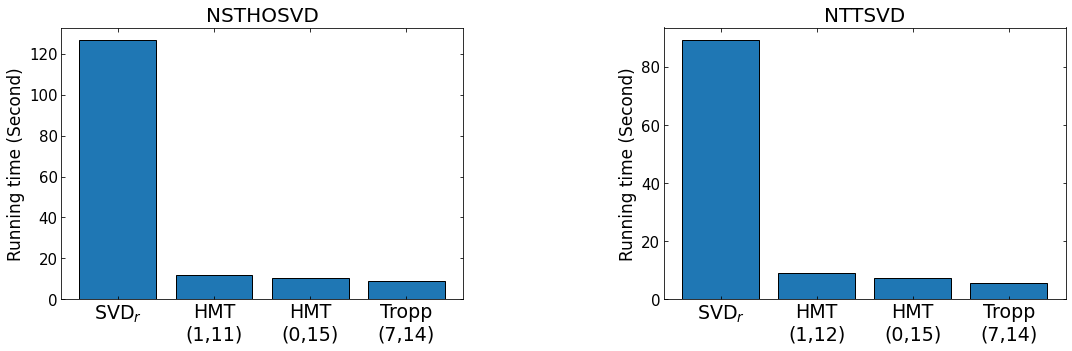

In [322]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=20,
                          ylabelsize=17,
                          xticksize=19,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True)

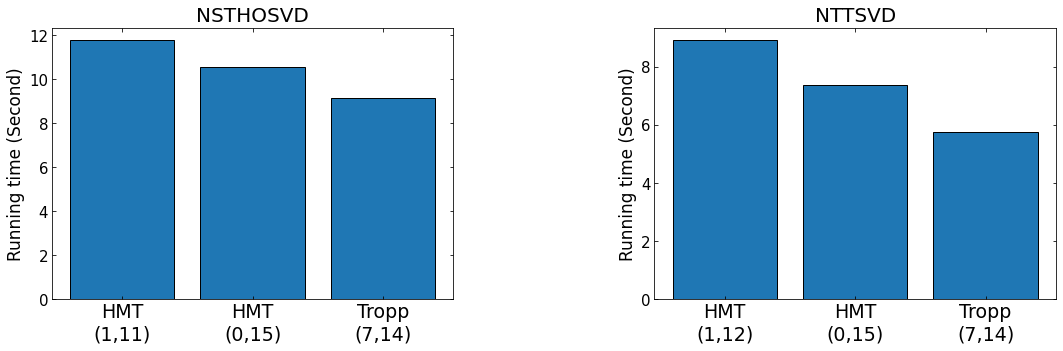

In [323]:
fig, ax = ex.plotRuntimes(figsize=(18, 5),
                          titlesize=20,
                          ylabelsize=17,
                          xticksize=19,
                          yticksize=15,
                          wspace=0.5,
                          paramsNewLine=True,
                          exclude=[0])

In [296]:
ex.run(itersNum=itersNum)

NTTSVD
------------------------------------
SVD$_r$                  |  98.95 s.
HMT(1,12), Rad           |  14.04 s.
HMT(0,15), Rad           |  13.15 s.
Tropp(7,14), Rad         |  11.68 s.
------------------------------------
NSTHOSVD
------------------------------------
SVD$_r$                  |  96.94 s.
HMT(1,11), Rad           |  15.15 s.
HMT(0,15), Rad           |  13.24 s.
Tropp(7,14), Rad         |  12.43 s.
------------------------------------
NLRT
------------------------------------
SVD$_r$                  | 381.47 s.
------------------------------------


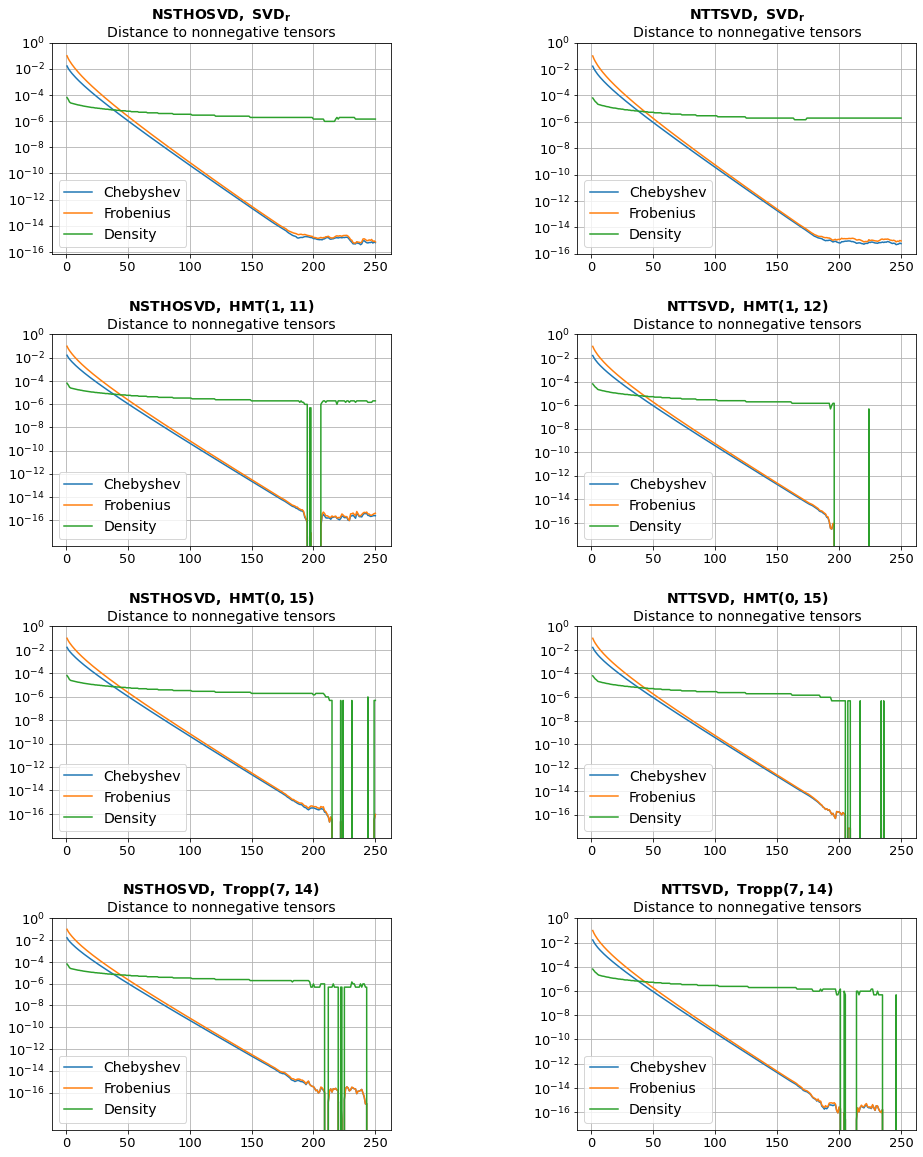

In [315]:
fig, ax = ex.plotConvergence(nlrt=False,
                             figsize=(15.5, 20),
                             yticks=[10**(-x) for x in range(0, 17, 2)],
                             hspace=0.38, wspace=0.55,
                             titlesize=14,
                             ticksize=13,
                             legendsize=14,
                             legendloc='lower left')

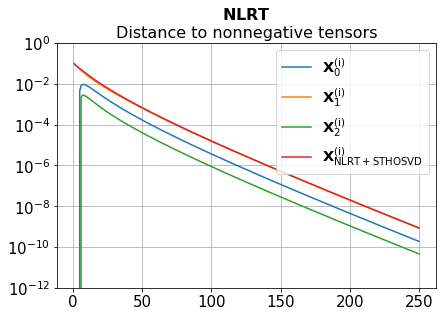

In [305]:
fig, ax = ex.plotConvergence(nttsvd=False,
                       nsthosvd=False,
                       nlrt=True,
                       figsize=(6.8, 4.5),
                       titlesize=16,
                       ticksize=15,
                       legendsize=14.5,
                       yticks=[10**(-x) for x in range(0, 13, 2)])

In [298]:
ex.printErrors()

| NTTSVD                   | relative error (fro) | relative error (che) | r2_score |
-------------------------------------------------------------------------------------
| SVD$_r$                  | 0.078820710858905962 | 0.394445165838060552 | 0.979003 |
| HMT(1,12), Rad           | 0.078820710858910237 | 0.394445165838151146 | 0.979003 |
| HMT(0,15), Rad           | 0.078820710858911583 | 0.394445165838159251 | 0.979003 |
| Tropp(7,14), Rad         | 0.078818072942617570 | 0.394658664199786124 | 0.979004 |
-------------------------------------------------------------------------------------
| NSTHOSVD                 | relative error (fro) | relative error (che) | r2_score |
-------------------------------------------------------------------------------------
| SVD$_r$                  | 0.078947343689500044 | 0.395001547796862029 | 0.978935 |
| HMT(1,11), Rad           | 0.078947343689502847 | 0.395001547797027119 | 0.978935 |
| HMT(0,15), Rad           | 0.078947343689507538 | 0.

In [299]:
ex.printNegativePart()

| NTTSVD                   | negative elements (%) |
----------------------------------------------------
| SVD$_r$                  |             0.0001907 |
| HMT(1,12)                |             0.0000000 |
| HMT(0,15)                |             0.0000000 |
| Tropp(7,14)              |             0.0000000 |
| NSTHOSVD                 | negative elements (%) |
----------------------------------------------------
| SVD$_r$                  |             0.0001431 |
| HMT(1,11)                |             0.0001907 |
| HMT(0,15)                |             0.0000477 |
| Tropp(7,14)              |             0.0000000 |

----------------------------------------------------------------
| NLRT                     | negative elements (%) |       X_i |
----------------------------------------------------------------
| SVD$_r$                  |             0.0003338 |       X_0 |
|                          |             0.0003338 |       X_1 |
|                          |          